Single Race Exploratory Data Analysis

This notebook explores and wrangles telemetry data from the Fast-F1 API for critical turns in a single race. It establishes a structured workflow for data acquisition, preparation, and initial exploration before scaling to multi-race analysis. Descriptive statistics and preliminary visualizations are generated to provide insights into the data, identify patterns or anomalies, and guide subsequent feature engineering and modeling decisions.

NOTE: This notebook will not compile as standalone. Please pull down the project from GitHub (git clone https://github.com/yourusername/f1-driving-style-analytics-tool.git) and install the necessary dependencies. Further instruction is included in the README.md

The code below adds the parent directory to Python’s module search path and configures logging to suppress all FastF1 logs below the warning level. This will enable subsequent code blocks that use imports to work seamlessly and keep my resulting code compilations clean and easy to read.

In [1]:
import sys
import os
import logging

root = os.path.abspath("..")
sys.path.append(root)

logging.getLogger('fastf1').setLevel(logging.WARNING)

In this section, I import Python libraries for data visualization, numerical analysis, and working with Pandas dataframes that the FastF1 API is primarily structured with. I also import custom functions and modules for preprocessing F1 data and constants. To support full visibility into the datasets without truncation, I configure Pandas display options to show all rows and columns.

In [2]:
from src.data import f1_data
from src.utils import f1_constants, f1_pandas_helpers
from src.preprocessing import telemetry_cleaning, feature_engineering
from src.viz import plots

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # reset_option to compact dataframe view
pd.set_option('display.max_columns', None)


The following code initializes a single F1 race session by defining parameters such as year, location, and session type. These values are passed into the custom F1Session class (from f1_data.py), which creates a session object built on top of Fast-F1. This object provides access to race data as well as custom functions I’ve implemented.

The session parameters were chosen to best match Tier 1 control qualities:

- Weather: Abu Dhabi (clear, dry conditions)
- Max Speed: C5 Ultra Soft Tires
- Minimize Outliers: Qualifying Sessions (Q3 & Q2)
- Traffic: Avoid tow laps to avoid slipstream bias

In [3]:
year = 2024
grand_prix = f1_constants.F1Constants.LOCATIONS["Abu Dhabi"]
session_type = f1_constants.F1Constants.SESSIONS["Q"]

session = f1_data.F1Session(year, grand_prix, session_type)

req         WARNING 	DEFAULT CACHE ENABLED! (716.91 MB) /Users/phillipsmith/Library/Caches/fastf1
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '55', '27', '1', '10', '63', '14', '77', '11', '22', '30', '18', '16', '20', '23', '24', '44', '43', '61']


All drivers who participated in the specific location's Q2 and Q3 sessions will be analyzed and assigned variables to be identified by their three-letter name code. Q3 data will be used for each driver whenever available; otherwise, Q2 data will be selected.

In [4]:
norris = f1_constants.F1Constants.DRIVERS["Lando Norris"]
piastri = f1_constants.F1Constants.DRIVERS["Oscar Piastri"]
verstappen = f1_constants.F1Constants.DRIVERS["Max Verstappen"]
perez = f1_constants.F1Constants.DRIVERS["Sergio Perez"]
sainz = f1_constants.F1Constants.DRIVERS["Carlos Sainz"]
leclerc = f1_constants.F1Constants.DRIVERS["Charles Leclerc"]
bottas = f1_constants.F1Constants.DRIVERS["Valtteri Bottas"]
alonso = f1_constants.F1Constants.DRIVERS["Fernando Alonso"]
stroll = f1_constants.F1Constants.DRIVERS["Lance Stroll"]
gasly = f1_constants.F1Constants.DRIVERS["Pierre Gasly"]
hulkenberg = f1_constants.F1Constants.DRIVERS["Nico Hulkenberg"]
magnussen = f1_constants.F1Constants.DRIVERS["Kevin Magnussen"]
lawson = f1_constants.F1Constants.DRIVERS["Liam Lawson"]
tsunoda = f1_constants.F1Constants.DRIVERS["Yuki Tsunoda"]
russell = f1_constants.F1Constants.DRIVERS["George Russell"]

drivers = [norris, piastri, verstappen, perez, sainz, leclerc, bottas, alonso, stroll, gasly, hulkenberg, magnussen, lawson, tsunoda, russell]

The code extracts circuit information for the session’s corners. The `critical_turn` array identifies corners where driver behavior is especially important for sector and overall lap performance. Adjusting the `radius` value controls how much telemetry around each turn is included, allowing you to visualize throttle and braking traces at the desired level of detail.

In [5]:
corner_position = session.get_circuit_info().corners
corner_position_cleaned = telemetry_cleaning.clean_circuit_corner_data(corner_position)

# 16 --> 2500, 12 --> 1500
critical_turn = [16]
radius = 2500

corner_position_cleaned

,Turn,X (1/10 m),Y (1/10 m),Angle (°),Distance (1/10 m)
0,1,4294.859375,2690.717773,-35.340600,377.851945
1,2,3848.351318,4987.570801,42.198164,626.674566
2,3,2206.551025,6155.120117,-163.169332,834.459836
3,4,2378.656250,8052.805176,-8.298533,1009.587697
4,5,1839.358276,11771.707031,84.326847,1416.310910
5,6,-2150.159424,655.311096,-148.988037,2616.829683
6,7,-1583.492065,587.163330,46.320930,2677.365930
7,8,-823.991882,-1256.985107,-144.588429,2877.258977
8,9,5774.805664,-4917.836914,-21.958205,3682.011370
9,10,3125.774414,-3602.140381,82.890762,4026.195705


For each driver, the telemetry from their fastest qualifying lap is isolated by filtering based on sector timestamps. These sector datasets are then cleaned, enriched with derived features, and filtered by turn to focus on the segments most informative for analyzing driver behavior and responses in complex areas.

Q3 data for Lando Norris, McLaren

In [6]:
q1, q2, q3 = session.get_laps(norris).split_qualifying_sessions()
norris_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

norris_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_1_start, end=sector_1_end)
norris_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector1_telemetry, norris)

norris_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_1_end, end=sector_2_end)
norris_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector2_telemetry, norris)

norris_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_2_end, end=sector_3_end)
norris_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector3_telemetry, norris)
norris_sector3_telemetry_features = feature_engineering.TelemetryFeatures(norris_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

norris_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(norris_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
norris_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
8558,NOR,0 days 01:18:13.993000,0 days 00:18:34.264000,11788.536190,71.510864,3.463562,-3.287628e+01,0.353185,6,100.000000,0,25719.691919,299.000000,-260.000000,-227.000000
8559,NOR,0 days 01:18:14.038000,0 days 00:18:34.309000,11813.000000,71.666724,1.984129,-1.430736e-05,0.202325,6,100.000000,0,25722.935556,271.637451,-261.959337,-226.446575
8560,NOR,0 days 01:18:14.273000,0 days 00:18:34.544000,10724.446132,72.132994,1.984126,-1.837150e+01,0.202325,6,100.000000,0,25739.903240,106.000000,-252.000000,-223.000000
8561,NOR,0 days 01:18:14.318000,0 days 00:18:34.589000,10516.000000,72.222280,1.157408,-8.036501e-13,0.118023,6,100.000000,0,25743.157778,59.851033,-241.062621,-222.323425
8562,NOR,0 days 01:18:14.494000,0 days 00:18:34.765000,10545.333333,72.425984,1.157408,1.808452e+01,0.118023,6,100.000000,0,25755.906132,-131.000000,-183.000000,-220.000000
8563,NOR,0 days 01:18:14.558000,0 days 00:18:34.829000,10556.000000,72.500058,2.314817,-1.287663e-04,0.236046,7,100.000000,0,25760.557778,-173.796843,-167.953880,-219.507971
8564,NOR,0 days 01:18:14.793000,0 days 00:18:35.064000,10613.770849,73.044040,2.314787,-2.314757e+02,0.236043,7,100.000000,0,25777.724782,-249.000000,-127.000000,-219.000000
8565,NOR,0 days 01:18:14.798000,0 days 00:18:35.069000,10615.000000,73.055614,1.157408,-9.645069e+00,0.118023,7,100.000000,0,25778.091111,-251.103065,-125.688249,-218.996705
8566,NOR,0 days 01:18:15.038000,0 days 00:18:35.309000,10583.000000,73.333392,-1.157408,-5.157911e-13,-0.118023,7,100.000000,0,25795.691111,-395.695753,-27.324701,-219.006689
8567,NOR,0 days 01:18:15.134000,0 days 00:18:35.405000,10587.800000,73.222281,-1.157408,2.411267e+01,-0.118023,7,100.000000,0,25802.704040,-468.000000,51.000000,-219.000000


Descriptive Statistics - Lando Norris

In [7]:
norris_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(norris_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
norris_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(norris, norris_turn_dfs)
norris_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,NOR,16,63,75.277838,57.344982,57.222268,13.565218,16.66668,-0.661309,2.314787,12.658388,2893.563761,43.179675,-1.087565e-13,382.210859,1.699528,-0.067435,0.236043,1.290796,4,2,69.613554,42.409431,1


Visualizations - Lando Norris

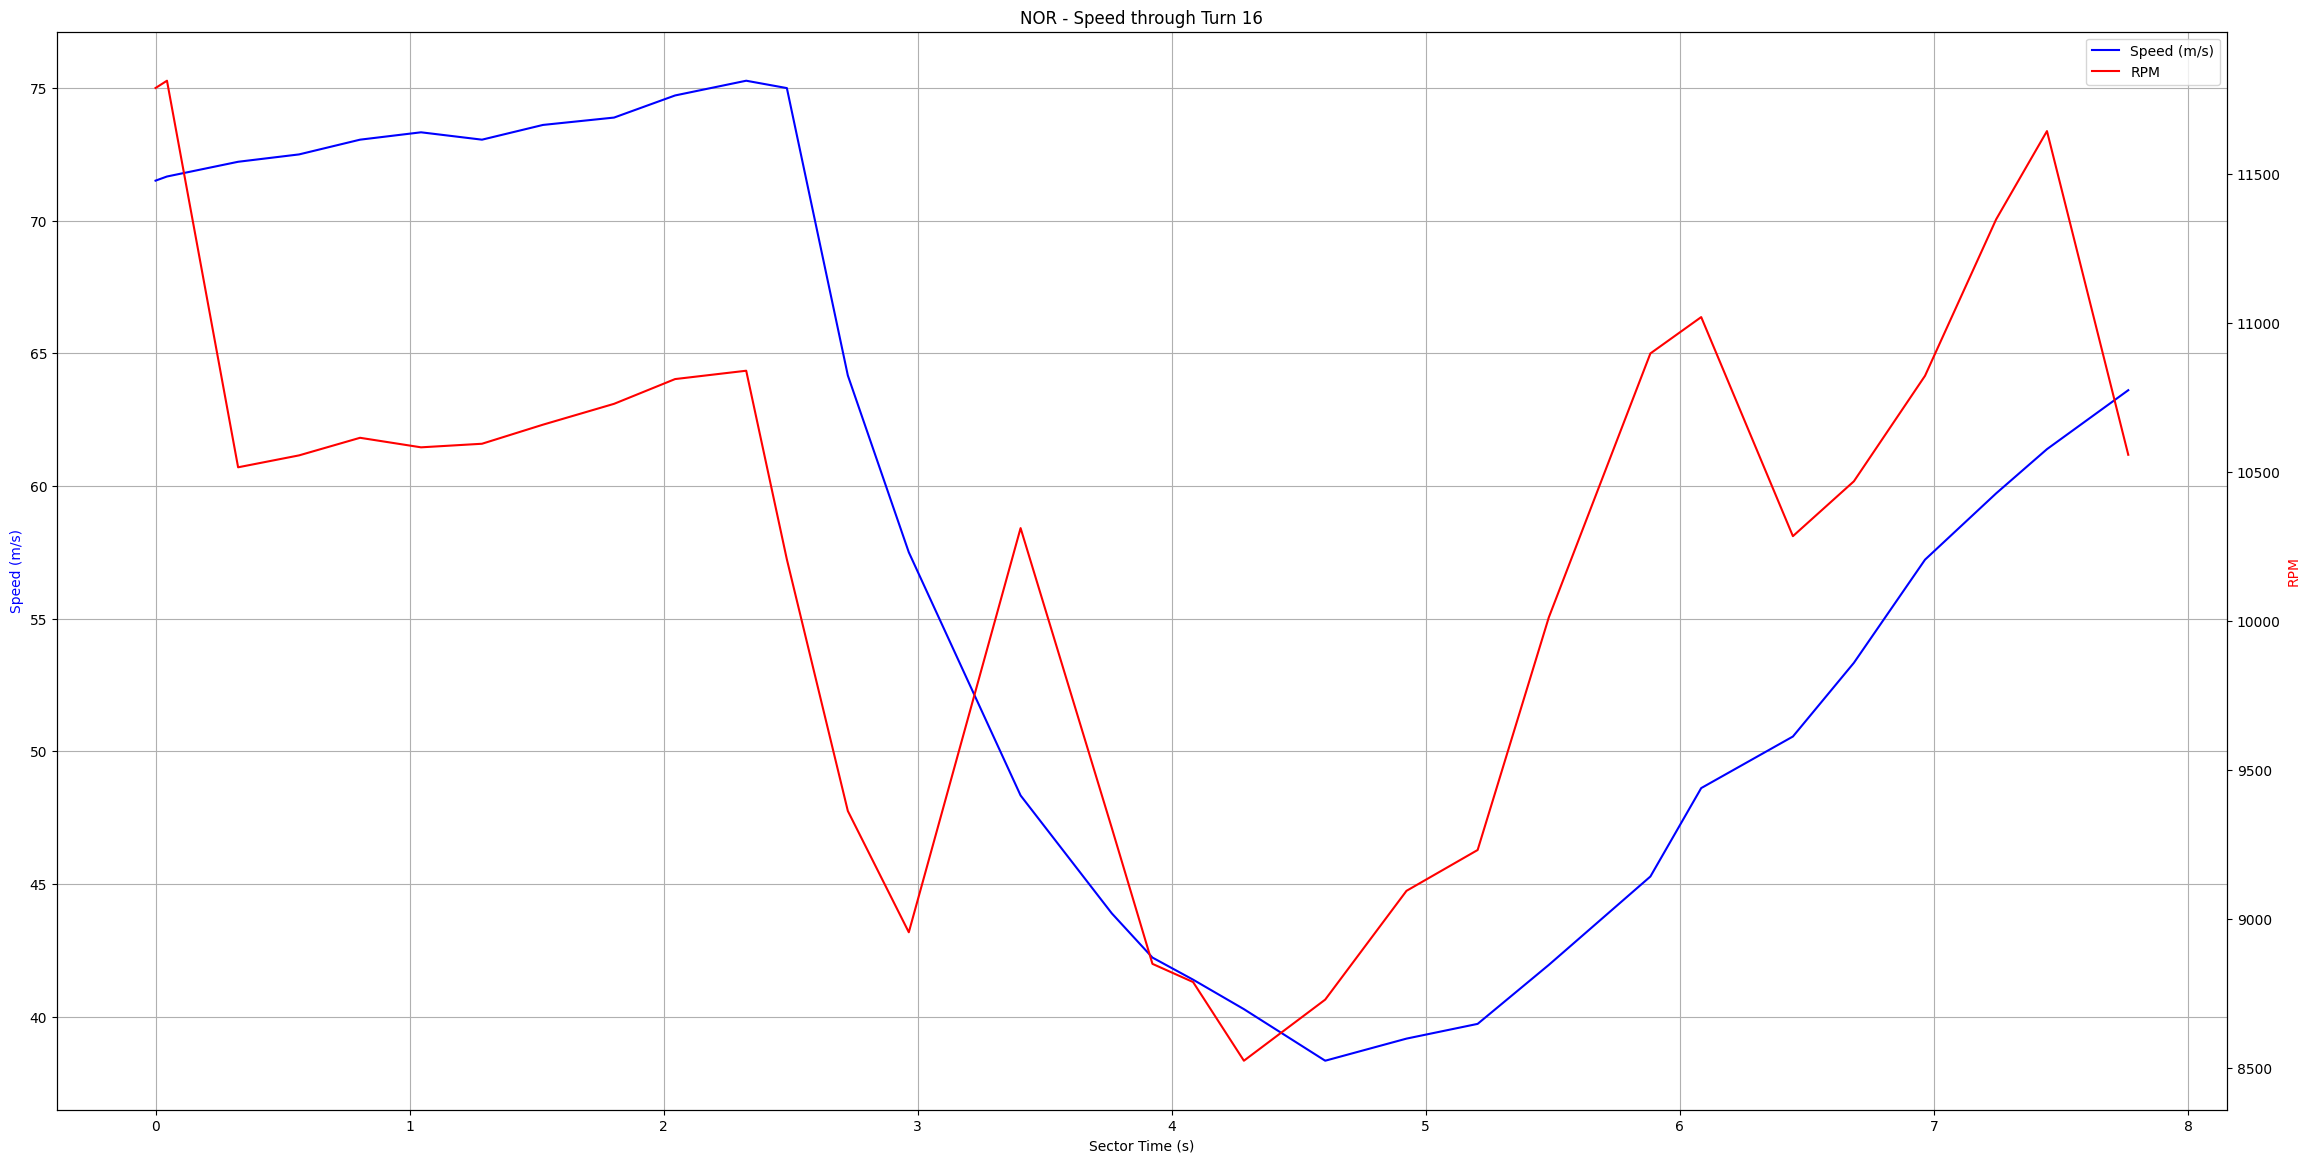

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Make a copy for plotting (do not overwrite the original)
df_plot = norris_corner_telemetry.copy()

# --- Ensure 'SectorTime (s)' exists as a column ---
if 'SectorTime (s)' not in df_plot.columns:
    df_plot = df_plot.reset_index()

# --- Safely convert to seconds ---
df_plot['SectorTime (s)'] = pd.to_timedelta(
    df_plot['SectorTime (s)'].astype(str),
    errors='coerce'
).dt.total_seconds()

# --- Normalize time to start at zero ---
df_plot['SectorTime (s)'] -= df_plot['SectorTime (s)'].iloc[0]

# --- Set as index ---
df_plot = df_plot.set_index('SectorTime (s)', drop=True)

# --- Create plot ---
fig, ax1 = plt.subplots(figsize=(28, 14))

# Speed
speed_line, = ax1.plot(
    df_plot.index,
    df_plot['Speed (m/s)'],
    color='blue',
    label='Speed (m/s)'
)
ax1.set_xlabel('Sector Time (s)')
ax1.set_ylabel('Speed (m/s)', color='blue')

# RPM
ax2 = ax1.twinx()
rpm_line, = ax2.plot(
    df_plot.index,
    df_plot['RPM'],
    color='red',
    label='RPM'
)
ax2.set_ylabel('RPM', color='red')

# Legends
lines = [speed_line, rpm_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title(f"{norris} - Speed through Turn {critical_turn[0]}")
ax1.grid(True)
plt.show()


Q3 data for Oscar Piastri, McLaren

In [9]:
q1, q2, q3 = session.get_laps(piastri).split_qualifying_sessions()
piastri_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

piastri_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_1_start, end=sector_1_end)
piastri_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector1_telemetry, piastri)

piastri_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_1_end, end=sector_2_end)
piastri_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector2_telemetry, piastri)

piastri_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_2_end, end=sector_3_end)
piastri_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector3_telemetry, piastri)
piastri_sector3_telemetry_features = feature_engineering.TelemetryFeatures(piastri_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

piastri_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(piastri_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
piastri_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
8332,PIA,0 days 01:17:41.913000,0 days 00:18:05.658000,11647.125062,70.932597,3.968251,-4.188703e+01,0.404649,6,99.000000,0,25717.834193,341.000000,-257.000000,-228.000000
8333,PIA,0 days 01:17:41.958000,0 days 00:18:05.703000,11691.000000,71.111168,2.083335,-3.851086e-13,0.212441,6,99.000000,0,25721.048889,311.450849,-260.679844,-227.531454
8334,PIA,0 days 01:17:42.214000,0 days 00:18:05.959000,10919.160000,71.644502,2.083335,-2.411267e+00,0.212441,6,99.000000,0,25739.440854,229.000000,-262.000000,-225.000000
8335,PIA,0 days 01:17:42.358000,0 days 00:18:06.103000,10485.000000,71.944502,1.736113,-8.493206e-12,0.177034,7,99.000000,0,25749.826667,132.230549,-255.351982,-223.374417
8336,PIA,0 days 01:17:42.394000,0 days 00:18:06.139000,10490.175000,72.007002,1.736113,2.166726e-13,0.177034,7,99.000000,0,25752.424772,106.000000,-252.000000,-223.000000
8337,PIA,0 days 01:17:42.518000,0 days 00:18:06.263000,10508.000000,72.222280,1.736113,-2.303713e-12,0.177034,7,99.000000,0,25761.382222,18.514822,-233.744431,-221.900994
8338,PIA,0 days 01:17:42.654000,0 days 00:18:06.399000,10508.000000,72.458391,1.736112,2.411267e+01,0.177034,7,99.000000,0,25771.236843,-75.000000,-204.000000,-221.000000
8339,PIA,0 days 01:17:42.678000,0 days 00:18:06.423000,10508.000000,72.500058,2.314817,1.135455e-13,0.236046,7,99.000000,0,25772.982222,-91.553552,-197.959636,-220.869866
8340,PIA,0 days 01:17:42.854000,0 days 00:18:06.599000,10570.333333,72.907466,2.314817,-6.329579e+01,0.236046,7,99.733333,0,25785.842002,-211.000000,-147.000000,-220.000000
8341,PIA,0 days 01:17:42.918000,0 days 00:18:06.663000,10593.000000,73.055614,-1.736114,3.030521e-05,-0.177034,7,100.000000,0,25790.515556,-251.430839,-126.079797,-219.560392


Descriptive Statistics - Oscar Piastri

In [10]:
piastri_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(piastri_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
piastri_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(piastri, piastri_turn_dfs)
piastri_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,PIA,16,67,75.277838,57.537776,59.168099,13.741954,12.345689,-0.78002,2.083335,11.235878,2083.112778,56.30214,1.233581e-13,326.334141,1.25891,-0.07954,0.212441,1.145741,5,2,66.941419,43.447465,1


Q3 data for Max Verstappen, Red Bull

In [11]:
q1, q2, q3 = session.get_laps(verstappen).split_qualifying_sessions()
verstappen_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

verstappen_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_1_start, end=sector_1_end)
verstappen_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector1_telemetry, verstappen)

verstappen_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_1_end, end=sector_2_end)
verstappen_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector2_telemetry, verstappen)

verstappen_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_2_end, end=sector_3_end)
verstappen_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector3_telemetry, verstappen)
verstappen_sector3_telemetry_features = feature_engineering.TelemetryFeatures(verstappen_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

verstappen_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(verstappen_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
verstappen_corner_telemetry


,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
9309,VER,0 days 01:09:41.674000,0 days 00:20:36.971000,11430.942789,70.273865,1.984256,586.156059,0.202338,6,100.000000,0,10050.666696,328.000000,-258.000000,-227.000000
9310,VER,0 days 01:09:41.676000,0 days 00:20:36.973000,11432.000000,70.277834,3.156568,0.000013,0.321880,6,100.000000,0,10050.808333,326.548592,-258.235482,-226.974118
9311,VER,0 days 01:09:42.073000,0 days 00:20:37.370000,11570.047705,71.530991,3.156573,-33.034029,0.321881,6,100.000000,0,10079.243187,135.000000,-256.000000,-223.000000
9312,VER,0 days 01:09:42.116000,0 days 00:20:37.413000,11585.000000,71.666724,1.736110,0.000048,0.177034,6,100.000000,0,10082.341667,75.082419,-242.906664,-222.299582
9313,VER,0 days 01:09:42.194000,0 days 00:20:37.491000,11434.606497,71.802141,1.736113,-1.434808,0.177034,6,100.000000,0,10087.966229,-44.000000,-215.000000,-221.000000
9314,VER,0 days 01:09:42.436000,0 days 00:20:37.733000,10968.000000,72.222280,1.388890,-1.984147,0.141627,7,100.000000,0,10105.452778,-246.632094,-141.719550,-219.165977
9315,VER,0 days 01:09:42.636000,0 days 00:20:37.933000,10490.000000,72.500058,0.992061,0.000234,0.101162,7,100.000000,0,10119.952778,-322.171555,-82.573009,-219.006185
9316,VER,0 days 01:09:42.653000,0 days 00:20:37.950000,10492.003564,72.516923,0.992065,-3.772108,0.101162,7,100.000000,0,10121.187831,-329.000000,-77.000000,-219.000000
9317,VER,0 days 01:09:42.916000,0 days 00:20:38.213000,10523.000000,72.777836,0.000000,0.000000,0.000000,7,100.000000,0,10140.330556,-441.924475,22.088065,-219.022258
9318,VER,0 days 01:09:43.014000,0 days 00:20:38.311000,10506.462522,72.777836,0.000000,14.000900,0.000000,7,100.000000,0,10147.461189,-485.000000,71.000000,-219.000000


Descriptive Statistics - Max Verstappen

In [12]:
verstappen_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(verstappen_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
verstappen_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(verstappen, verstappen_turn_dfs)
verstappen_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,VER,16,62,75.00006,55.634601,53.408607,14.003103,11.904771,-1.180369,1.736114,11.893096,17731.32362,517.491471,0.000046,2659.30174,1.213949,-0.120364,0.177034,1.212758,4,2,69.351849,41.448633,1


Q3 data for Sergio Perez, Red Bull

In [13]:
q1, q2, q3 = session.get_laps(perez).split_qualifying_sessions()
perez_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

perez_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_1_start, end=sector_1_end)
perez_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector1_telemetry, perez)

perez_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_1_end, end=sector_2_end)
perez_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector2_telemetry, perez)

perez_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_2_end, end=sector_3_end)
perez_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector3_telemetry, perez)
perez_sector3_telemetry_features = feature_engineering.TelemetryFeatures(perez_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

perez_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(perez_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
perez_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
7541,PER,0 days 01:16:04.854000,0 days 00:16:23.151000,11219.699994,69.353230,3.968268,1.293992e+02,0.404651,6,100.000000,0,25741.984373,401.000000,-251.000000,-229.000000
7542,PER,0 days 01:16:04.877000,0 days 00:16:23.174000,11222.000000,69.444500,6.944450,-3.255211e+01,0.708137,6,100.000000,0,25743.597222,385.338947,-253.001193,-228.722196
7543,PER,0 days 01:16:05.037000,0 days 00:16:23.334000,11375.000000,70.555612,1.736112,-2.170156e+00,0.177034,6,100.000000,0,25754.886111,291.524983,-262.677418,-226.618213
7544,PER,0 days 01:16:05.197000,0 days 00:16:23.494000,11412.000000,70.833390,1.388888,7.966853e-05,0.141627,6,100.000000,0,25766.219444,203.834192,-262.729188,-224.463517
7545,PER,0 days 01:16:05.234000,0 days 00:16:23.531000,11431.424966,70.884779,1.388891,1.278111e+01,0.141627,6,100.000000,0,25768.843988,181.000000,-261.000000,-224.000000
7546,PER,0 days 01:16:05.397000,0 days 00:16:23.694000,11517.000000,71.111168,3.472212,7.689356e-04,0.354067,6,100.000000,0,25780.441667,70.795715,-245.424615,-222.158774
7547,PER,0 days 01:16:05.414000,0 days 00:16:23.711000,11524.295806,71.170196,3.472225,1.912413e-05,0.354068,6,100.000000,0,25781.657916,59.000000,-243.000000,-222.000000
7548,PER,0 days 01:16:05.554000,0 days 00:16:23.851000,11584.379139,71.656307,3.472228,-3.660481e+01,0.354069,6,100.000000,0,25791.724619,-38.000000,-217.000000,-221.000000
7549,PER,0 days 01:16:05.637000,0 days 00:16:23.934000,11620.000000,71.944502,0.434028,2.422030e+00,0.044259,6,100.000000,0,25797.708333,-94.946802,-196.280401,-220.707602
7550,PER,0 days 01:16:06.277000,0 days 00:16:24.574000,11755.000000,72.222280,1.984127,9.276370e-06,0.202325,6,100.000000,0,25843.930556,-495.268936,87.697025,-222.206884


Descriptive Statistics - Sergio Perez

In [14]:
perez_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(perez_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
perez_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(perez, perez_turn_dfs)
perez_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,PER,16,64,74.444504,55.772932,56.027389,13.757684,13.889196,-0.468533,2.893515,13.122799,1519.097022,10.13975,0.00002,269.502697,1.416304,-0.047777,0.295056,1.338153,3,2,70.301491,42.023627,1


Q3 data for Carlos Sainz, Ferrari

In [15]:
q1, q2, q3 = session.get_laps(sainz).split_qualifying_sessions()
sainz_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

sainz_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_1_start, end=sector_1_end)
sainz_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector1_telemetry, sainz)

sainz_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_1_end, end=sector_2_end)
sainz_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector2_telemetry, sainz)

sainz_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_2_end, end=sector_3_end)
sainz_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector3_telemetry, sainz)
sainz_sector3_telemetry_features = feature_engineering.TelemetryFeatures(sainz_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

sainz_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(sainz_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
sainz_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
8137,SAI,0 days 01:18:07.718000,0 days 00:17:37.084000,11722.000000,70.277834,3.472240,-1.079673e-03,0.354070,6,100.000000,0,25770.270278,436.629933,-246.587648,-229.159215
8138,SAI,0 days 01:18:07.733000,0 days 00:17:37.099000,11707.937440,70.329918,3.472224,8.573065e-06,0.354068,6,100.000000,0,25771.330306,426.000000,-248.000000,-229.000000
8139,SAI,0 days 01:18:07.894000,0 days 00:17:37.260000,11557.000000,70.888946,3.472225,-1.808451e+01,0.354068,6,100.000000,0,25782.769596,308.000000,-260.000000,-227.000000
8140,SAI,0 days 01:18:07.958000,0 days 00:17:37.324000,11497.000000,71.111168,2.314817,-4.702121e-13,0.236046,6,100.000000,0,25787.336944,264.569284,-262.032686,-226.075216
8141,SAI,0 days 01:18:08.094000,0 days 00:17:37.460000,10907.666667,71.425983,2.314817,1.310917e-12,0.236046,6,100.000000,0,25797.069331,177.000000,-260.000000,-224.000000
8142,SAI,0 days 01:18:08.198000,0 days 00:17:37.564000,10457.000000,71.666724,2.314817,-7.515356e-13,0.236046,7,100.000000,0,25804.536944,107.030508,-251.824269,-222.496501
8143,SAI,0 days 01:18:08.354000,0 days 00:17:37.720000,10514.200000,72.027835,2.314817,1.377867e+01,0.236046,7,100.000000,0,25815.781520,-2.000000,-228.000000,-221.000000
8144,SAI,0 days 01:18:08.438000,0 days 00:17:37.804000,10545.000000,72.222280,3.472225,3.061878e-12,0.354068,7,100.000000,0,25821.870278,-61.649453,-208.946098,-220.976903
8145,SAI,0 days 01:18:08.514000,0 days 00:17:37.880000,10570.016667,72.486169,3.472225,-1.512293e+01,0.354068,7,100.000000,0,25827.404639,-115.000000,-189.000000,-221.000000
8146,SAI,0 days 01:18:08.678000,0 days 00:17:38.044000,10624.000000,73.055614,0.992064,8.971582e-13,0.101162,7,100.000000,0,25839.403611,-224.674783,-140.294989,-219.917778


Descriptive Statistics - Carlos Sainz

In [16]:
sainz_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(sainz_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
sainz_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(sainz, sainz_turn_dfs)
sainz_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,SAI,16,64,75.833394,57.178967,58.33338,14.391193,17.857162,0.032434,2.314817,11.759878,552.403137,-22.779047,-5.285221e-13,201.569569,1.820924,0.003307,0.236046,1.199174,4,2,71.658061,41.90848,1


Q2 data for Charles Leclerc, Ferrari

In [17]:
q1, q2, q3 = session.get_laps(leclerc).split_qualifying_sessions()
leclerc_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

leclerc_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_1_start, end=sector_1_end)
leclerc_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector1_telemetry, leclerc)

leclerc_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_1_end, end=sector_2_end)
leclerc_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector2_telemetry, leclerc)

leclerc_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_2_end, end=sector_3_end)
leclerc_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector3_telemetry, leclerc)
leclerc_sector3_telemetry_features = feature_engineering.TelemetryFeatures(leclerc_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

leclerc_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(leclerc_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
leclerc_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
10526,LEC,0 days 00:58:18.194000,0 days 00:23:19.343000,11772.000000,70.555612,4.166670,-1.687539e-12,0.424882,6,100.000000,0,25716.176111,394.000000,-251.000000,-229.000000
10527,LEC,0 days 00:58:18.334000,0 days 00:23:19.483000,11282.000000,71.138946,4.166670,-3.637569e+01,0.424882,6,100.000000,0,25726.160004,297.000000,-260.000000,-227.000000
10528,LEC,0 days 00:58:18.394000,0 days 00:23:19.543000,11072.000000,71.388946,1.984129,-1.294798e-12,0.202325,6,100.000000,0,25730.453889,258.090249,-262.683605,-225.944675
10529,LEC,0 days 00:58:18.554000,0 days 00:23:19.703000,10718.857143,71.706407,1.984129,5.167001e+00,0.202325,6,100.000000,0,25741.938796,146.000000,-258.000000,-223.000000
10530,LEC,0 days 00:58:18.674000,0 days 00:23:19.823000,10454.000000,71.944502,2.604169,-6.266592e-13,0.265551,7,100.000000,0,25750.598333,24.017456,-229.257874,-221.434219
10531,LEC,0 days 00:58:18.854000,0 days 00:23:20.003000,10507.437500,72.413252,2.604169,-1.033400e+01,0.265551,7,100.000000,0,25763.677169,-159.000000,-171.000000,-220.000000
10532,LEC,0 days 00:58:18.994000,0 days 00:23:20.143000,10549.000000,72.777836,1.157408,-3.552714e-13,0.118023,7,100.000000,0,25773.887222,-227.495219,-144.189604,-219.379662
10533,LEC,0 days 00:58:19.194000,0 days 00:23:20.343000,10619.833333,73.009318,1.157408,5.787042e+00,0.118023,7,100.000000,0,25788.491364,-286.000000,-105.000000,-219.000000
10534,LEC,0 days 00:58:19.234000,0 days 00:23:20.383000,10634.000000,73.055614,1.388890,-4.940492e-13,0.141627,7,100.000000,0,25791.420556,-306.159139,-91.443600,-218.952332
10535,LEC,0 days 00:58:19.354000,0 days 00:23:20.503000,10697.000000,73.222281,1.388890,-6.076394e+01,0.141627,7,100.000000,0,25800.229157,-379.000000,-38.000000,-219.000000


Descriptive Statistics - Charles Leclerc

In [18]:
leclerc_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(leclerc_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
leclerc_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(leclerc, leclerc_turn_dfs)
leclerc_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,LEC,16,63,76.111172,57.834744,58.33338,14.015042,15.625013,0.12618,2.604169,13.469746,165.344552,1.055976,1.297663e-14,64.061786,1.593308,0.012867,0.265551,1.373532,5,1,76.71556,35.828167,1


Q3 data for Valtteri Bottas, Alfa Romeo

In [19]:
q1, q2, q3 = session.get_laps(bottas).split_qualifying_sessions()
bottas_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

bottas_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_1_start, end=sector_1_end)
bottas_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector1_telemetry, bottas)

bottas_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_1_end, end=sector_2_end)
bottas_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector2_telemetry, bottas)

bottas_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_2_end, end=sector_3_end)
bottas_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector3_telemetry, bottas)
bottas_sector3_telemetry_features = feature_engineering.TelemetryFeatures(bottas_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

bottas_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(bottas_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
bottas_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
7320,BOT,0 days 01:17:01.553000,0 days 00:15:49.948000,11642.553614,70.148866,1.984128,3.876080e-06,0.202325,6,100.000000,0,10063.959419,409.000000,-250.000000,-229.000000
7321,BOT,0 days 01:17:01.734000,0 days 00:15:50.129000,11762.142857,70.507993,1.984129,8.267202e+01,0.202325,6,100.000000,0,10076.733024,203.000000,-262.000000,-225.000000
7322,BOT,0 days 01:17:01.758000,0 days 00:15:50.153000,11778.000000,70.555612,3.968257,-9.212021e+00,0.404650,6,100.000000,0,10078.437778,181.538262,-262.520589,-224.520773
7323,BOT,0 days 01:17:02.038000,0 days 00:15:50.433000,11884.000000,71.666724,1.388891,-2.169893e-05,0.141627,6,100.000000,0,10098.504444,60.348387,-246.495528,-221.244410
7324,BOT,0 days 01:17:02.113000,0 days 00:15:50.508000,11629.562283,71.770891,1.388890,2.200168e-06,0.141627,6,100.000000,0,10103.907234,24.000000,-235.000000,-221.000000
7325,BOT,0 days 01:17:02.314000,0 days 00:15:50.709000,10947.670000,72.050058,1.388890,-1.866788e+00,0.141627,6,100.000000,0,10118.422464,-114.000000,-190.000000,-221.000000
7326,BOT,0 days 01:17:02.438000,0 days 00:15:50.833000,10527.000000,72.222280,1.157408,-4.421750e-13,0.118023,7,100.000000,0,10127.393333,-196.595325,-154.862897,-219.960674
7327,BOT,0 days 01:17:02.554000,0 days 00:15:50.949000,10553.100000,72.356539,1.157408,1.706777e-05,0.118023,7,100.000000,0,10135.794163,-269.000000,-116.000000,-219.000000
7328,BOT,0 days 01:17:02.678000,0 days 00:15:51.073000,10581.000000,72.500058,1.157410,-7.079260e-05,0.118023,7,100.000000,0,10144.793333,-343.059177,-66.582871,-218.919357
7329,BOT,0 days 01:17:02.713000,0 days 00:15:51.108000,10587.854179,72.540567,1.157408,-1.411473e+01,0.118023,7,100.000000,0,10147.338895,-363.000000,-51.000000,-219.000000


Descriptive Statistics - Valtteri Bottas

In [20]:
bottas_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(bottas_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
bottas_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(bottas, bottas_turn_dfs)
bottas_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,BOT,16,65,74.444504,57.549441,59.166714,13.680308,14.983879,-0.488292,1.388891,13.621176,1774.750391,37.859323,0.0,229.649207,1.52793,-0.049792,0.141627,1.388973,4,2,75.164263,38.759111,1


Q3 data for Fernando Alonso, Aston Martin

In [21]:
q1, q2, q3 = session.get_laps(alonso).split_qualifying_sessions()
alonso_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

alonso_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_1_start, end=sector_1_end)
alonso_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector1_telemetry, alonso)

alonso_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_1_end, end=sector_2_end)
alonso_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector2_telemetry, alonso)

alonso_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_2_end, end=sector_3_end)
alonso_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector3_telemetry, alonso)
alonso_sector3_telemetry_features = feature_engineering.TelemetryFeatures(alonso_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

alonso_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(alonso_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
alonso_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
8229,ALO,0 days 01:18:00.237000,0 days 00:17:50.771000,12015.000000,70.833390,1.984129,4.718448e-13,0.202325,6,99.000000,0,25718.475556,364.051918,-253.110857,-227.534285
8230,ALO,0 days 01:18:00.333000,0 days 00:17:50.867000,11544.600000,71.023866,1.984129,-7.018561e+00,0.202325,6,99.000000,0,25725.313948,275.000000,-262.000000,-226.000000
8231,ALO,0 days 01:18:00.517000,0 days 00:17:51.051000,10643.000000,71.388946,0.692713,2.367387e-13,0.070637,6,99.000000,0,25738.464444,182.880756,-264.599614,-224.075350
8232,ALO,0 days 01:18:00.653000,0 days 00:17:51.187000,10672.167087,71.483155,0.692713,-3.410280e-05,0.070637,6,99.000000,0,25748.191741,124.000000,-255.000000,-223.000000
8233,ALO,0 days 01:18:00.913000,0 days 00:17:51.447000,10727.927694,71.663260,0.692704,5.559041e+02,0.070636,6,99.000000,0,25766.842601,-56.000000,-211.000000,-221.000000
8234,ALO,0 days 01:18:00.918000,0 days 00:17:51.452000,10729.000000,71.666724,3.472225,-1.302084e+01,0.354068,7,99.000000,0,25767.202778,-59.546821,-209.840271,-220.970740
8235,ALO,0 days 01:18:01.078000,0 days 00:17:51.612000,10790.000000,72.222280,1.388890,-1.646831e-12,0.141627,7,99.000000,0,25778.758333,-168.494587,-166.922365,-220.204706
8236,ALO,0 days 01:18:01.114000,0 days 00:17:51.648000,10788.020000,72.272280,1.388890,7.771561e-12,0.141627,7,99.000000,0,25781.365034,-192.000000,-156.000000,-220.000000
8237,ALO,0 days 01:18:01.274000,0 days 00:17:51.808000,10779.220000,72.494502,1.388890,-3.472225e+02,0.141627,7,99.000000,0,25792.968263,-292.000000,-102.000000,-219.000000
8238,ALO,0 days 01:18:01.278000,0 days 00:17:51.812000,10779.000000,72.500058,0.000000,0.000000e+00,0.000000,7,99.000000,0,25793.258333,-294.379454,-100.507555,-218.986468


Descriptive Statistics - Fernando Alonso

In [22]:
alonso_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(alonso_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
alonso_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(alonso, alonso_turn_dfs)
alonso_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,ALO,16,63,74.722282,57.91623,59.97227,13.422748,13.888939,-0.748079,1.984129,13.414703,2314.766131,47.916282,3.552714e-13,316.063358,1.416278,-0.076283,0.202325,1.367919,6,3,70.742826,41.05651,1


Q2 data for Lance Stroll, Aston Martin

In [23]:
q1, q2, q3 = session.get_laps(stroll).split_qualifying_sessions()
stroll_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

stroll_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_1_start, end=sector_1_end)
stroll_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector1_telemetry, stroll)

stroll_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_1_end, end=sector_2_end)
stroll_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector2_telemetry, stroll)

stroll_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_2_end, end=sector_3_end)
stroll_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector3_telemetry, stroll)
stroll_sector3_telemetry_features = feature_engineering.TelemetryFeatures(stroll_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

stroll_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(stroll_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
stroll_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
10471,STR,0 days 00:57:53.913000,0 days 00:23:12.532000,10548.000000,70.555612,2.777779,3.074043e-05,0.283255,7,99.000000,0,25722.391944,415.557565,-248.773593,-228.604169
10472,STR,0 days 00:57:54.034000,0 days 00:23:12.653000,10573.409987,70.891723,2.777782,-1.318573e+01,0.283255,7,99.000000,0,25730.989751,331.000000,-258.000000,-227.000000
10473,STR,0 days 00:57:54.113000,0 days 00:23:12.732000,10590.000000,71.111168,1.736110,8.887163e-05,0.177034,7,99.000000,0,25736.614167,275.356260,-261.224824,-226.377586
10474,STR,0 days 00:57:54.154000,0 days 00:23:12.773000,10597.431238,71.182349,1.736113,-6.252520e+00,0.177034,7,99.000000,0,25739.537798,247.000000,-262.000000,-226.000000
10475,STR,0 days 00:57:54.273000,0 days 00:23:12.892000,10619.000000,71.388946,0.992064,1.361616e-05,0.101162,7,99.000000,0,25748.036389,168.051706,-260.576829,-224.250214
10476,STR,0 days 00:57:54.354000,0 days 00:23:12.973000,10665.864249,71.469303,0.992065,1.052440e+01,0.101162,7,99.000000,0,25753.824480,110.000000,-253.000000,-223.000000
10477,STR,0 days 00:57:54.553000,0 days 00:23:13.172000,10781.000000,71.666724,3.086421,1.378583e-05,0.314727,7,99.000000,0,25768.103056,-65.371319,-202.983228,-221.000181
10478,STR,0 days 00:57:54.714000,0 days 00:23:13.333000,10789.497219,72.163638,3.086423,-3.295803e+01,0.314728,7,99.000000,0,25779.804046,-193.000000,-156.000000,-220.000000
10479,STR,0 days 00:57:54.913000,0 days 00:23:13.532000,10800.000000,72.777836,-3.472225,2.893567e+01,-0.354068,7,99.000000,0,25794.303056,-283.862540,-116.366698,-219.020142
10480,STR,0 days 00:57:55.073000,0 days 00:23:13.692000,10971.000000,72.222280,1.157482,-3.759541e-02,0.118030,7,99.000000,0,25805.858611,-360.743209,-53.186399,-218.993391


Descriptive Statistics - Lance Stroll

In [24]:
stroll_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(stroll_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
stroll_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(stroll, stroll_turn_dfs)
stroll_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,STR,16,61,74.444504,57.482511,58.33338,13.941375,15.625013,-0.430441,1.736113,13.80545,661.37619,15.956253,0.000013,94.039194,1.593308,-0.043893,0.177034,1.407764,4,3,73.034914,41.079768,1


Q3 data for Pierre Gasly, Alpine

In [25]:
q1, q2, q3 = session.get_laps(gasly).split_qualifying_sessions()
gasly_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

gasly_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_1_start, end=sector_1_end)
gasly_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector1_telemetry, gasly)

gasly_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_1_end, end=sector_2_end)
gasly_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector2_telemetry, gasly)

gasly_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_2_end, end=sector_3_end)
gasly_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector3_telemetry, gasly)
gasly_sector3_telemetry_features = feature_engineering.TelemetryFeatures(gasly_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

gasly_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(gasly_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
gasly_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
8405,GAS,0 days 01:17:32.475000,0 days 00:18:15.335000,11236.683396,69.020889,3.472223,-1.909911e+00,0.354068,6,100.000000,0,25737.862302,470.000000,-242.000000,-230.000000
8406,GAS,0 days 01:17:32.677000,0 days 00:18:15.537000,11336.000000,69.722278,3.086421,1.698994e-05,0.314727,6,100.000000,0,25751.960278,373.350537,-255.182649,-228.346296
8407,GAS,0 days 01:17:32.814000,0 days 00:18:15.674000,11429.616623,70.145118,3.086423,-3.460130e+00,0.314728,6,100.000000,0,25761.614245,317.000000,-259.000000,-227.000000
8408,GAS,0 days 01:17:33.037000,0 days 00:18:15.897000,11582.000000,70.833390,2.314814,8.867699e-05,0.236045,6,100.000000,0,25777.460278,173.260351,-261.022599,-223.777441
8409,GAS,0 days 01:17:33.094000,0 days 00:18:15.954000,11606.383306,70.965334,2.314819,-2.698429e-05,0.236046,6,100.000000,0,25781.528462,126.000000,-255.000000,-223.000000
8410,GAS,0 days 01:17:33.275000,0 days 00:18:16.135000,11683.811166,71.384317,2.314814,-4.743457e+00,0.236045,6,100.000000,0,25794.492446,-39.000000,-216.000000,-221.000000
8411,GAS,0 days 01:17:33.397000,0 days 00:18:16.257000,11736.000000,71.666724,1.736113,-3.293034e-13,0.177034,6,100.000000,0,25803.260278,-122.123768,-190.037265,-220.022027
8412,GAS,0 days 01:17:33.633000,0 days 00:18:16.493000,10735.950000,72.076447,1.736112,2.952561e+00,0.177034,6,100.000000,0,25820.283087,-240.000000,-133.000000,-219.000000
8413,GAS,0 days 01:17:33.717000,0 days 00:18:16.577000,10380.000000,72.222280,1.984128,1.324740e-05,0.202325,7,100.000000,0,25826.371389,-288.860420,-102.515532,-218.932598
8414,GAS,0 days 01:17:33.854000,0 days 00:18:16.714000,10359.939295,72.494105,1.984129,-2.081254e+01,0.202325,7,100.000000,0,25836.340336,-369.000000,-46.000000,-219.000000


Descriptive Statistics - Pierre Gasly

In [26]:
gasly_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(gasly_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
gasly_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(gasly, gasly_turn_dfs)
gasly_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,GAS,16,66,74.166726,57.621776,58.843301,13.281316,13.117298,-2.272275,2.149472,14.489769,179.597697,9.517023,0.000016,52.449046,1.337592,-0.231708,0.219185,1.477545,5,2,69.3713,42.447647,1


Q3 data for Nico Hulkenberg, Haas

In [27]:
q1, q2, q3 = session.get_laps(hulkenberg).split_qualifying_sessions()
hulkenberg_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

hulkenberg_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_1_start, end=sector_1_end)
hulkenberg_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector1_telemetry, hulkenberg)

hulkenberg_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_1_end, end=sector_2_end)
hulkenberg_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector2_telemetry, hulkenberg)

hulkenberg_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_2_end, end=sector_3_end)
hulkenberg_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector3_telemetry, hulkenberg)
hulkenberg_sector3_telemetry_features = feature_engineering.TelemetryFeatures(hulkenberg_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

hulkenberg_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(hulkenberg_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
hulkenberg_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
8478,HUL,0 days 01:17:18.117000,0 days 00:18:27.094000,11561.000000,69.722278,5.208318,1.290521e-03,0.531101,6,100.000000,0,25774.617778,474.889963,-240.643889,-230.150626
8479,HUL,0 days 01:17:18.134000,0 days 00:18:27.111000,11572.049958,69.810819,5.208340,-1.699693e+01,0.531103,6,100.000000,0,25775.811727,461.000000,-243.000000,-230.000000
8480,HUL,0 days 01:17:18.277000,0 days 00:18:27.254000,11665.000000,70.555612,2.777779,1.504666e-05,0.283255,6,100.000000,0,25785.906667,377.747786,-258.373584,-228.855538
8481,HUL,0 days 01:17:18.535000,0 days 00:18:27.512000,11830.764918,71.272279,2.777783,-1.141109e+01,0.283255,6,100.000000,0,25804.361803,253.000000,-262.000000,-226.000000
8482,HUL,0 days 01:17:18.677000,0 days 00:18:27.654000,11922.000000,71.666724,1.157407,2.990040e-05,0.118023,6,100.000000,0,25814.573333,100.969907,-247.967426,-223.015916
8483,HUL,0 days 01:17:18.734000,0 days 00:18:27.711000,11589.500373,71.732696,1.157409,1.264931e+00,0.118023,6,100.000000,0,25818.672469,46.000000,-241.000000,-222.000000
8484,HUL,0 days 01:17:18.917000,0 days 00:18:27.894000,10522.000000,71.944502,1.388891,-3.391129e-05,0.141627,6,100.000000,0,25831.840000,-55.061196,-217.590530,-220.481031
8485,HUL,0 days 01:17:19.075000,0 days 00:18:28.052000,10573.350042,72.163947,1.388886,3.306889e+01,0.141627,6,100.000000,0,25843.239020,-121.000000,-187.000000,-220.000000
8486,HUL,0 days 01:17:19.117000,0 days 00:18:28.094000,10587.000000,72.222280,2.777779,4.580843e-06,0.283255,7,100.000000,0,25846.284444,-144.951361,-176.004185,-219.822649
8487,HUL,0 days 01:17:19.314000,0 days 00:18:28.291000,10674.664972,72.769502,2.777780,2.962965e-04,0.283255,7,100.000000,0,25860.684366,-276.000000,-112.000000,-219.000000


Descriptive Statistics - Nico Hulkenberg

In [28]:
hulkenberg_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(hulkenberg_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
hulkenberg_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(hulkenberg, hulkenberg_turn_dfs)
hulkenberg_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,HUL,16,67,75.00006,58.366969,60.644493,13.758384,18.05562,-0.103456,2.314819,13.173994,2645.468092,-55.997452,2.180074e-13,605.386029,1.841161,-0.01055,0.236046,1.343373,4,2,74.656146,40.784947,1


Q2 data for Kevin Magnussen, Haas

In [29]:
q1, q2, q3 = session.get_laps(magnussen).split_qualifying_sessions()
magnussen_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

magnussen_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_1_start, end=sector_1_end)
magnussen_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector1_telemetry, magnussen)

magnussen_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_1_end, end=sector_2_end)
magnussen_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector2_telemetry, magnussen)

magnussen_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_2_end, end=sector_3_end)
magnussen_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector3_telemetry, magnussen)
magnussen_sector3_telemetry_features = feature_engineering.TelemetryFeatures(magnussen_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

magnussen_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(magnussen_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
magnussen_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
10125,MAG,0 days 00:56:49.473000,0 days 00:22:25.019000,11481.000000,69.444500,3.472205,9.860664e-04,0.354066,6,100.000000,0,25786.977222,473.084013,-240.853782,-230.251841
10126,MAG,0 days 00:56:49.495000,0 days 00:22:25.041000,11494.474922,69.520889,3.472226,-3.883971e+00,0.354069,6,100.000000,0,25788.519853,453.000000,-244.000000,-230.000000
10127,MAG,0 days 00:56:49.793000,0 days 00:22:25.339000,11677.000000,70.555612,2.314803,6.347047e-04,0.236044,6,100.000000,0,25809.555000,311.940425,-259.737368,-227.238146
10128,MAG,0 days 00:56:49.815000,0 days 00:22:25.361000,11691.055474,70.606538,2.314817,1.104747e-05,0.236046,6,100.000000,0,25811.118017,301.000000,-260.000000,-227.000000
10129,MAG,0 days 00:56:50.114000,0 days 00:22:25.660000,11882.083292,71.298668,2.314820,-2.967725e+01,0.236046,6,100.000000,0,25832.466923,96.000000,-251.000000,-223.000000
10130,MAG,0 days 00:56:50.153000,0 days 00:22:25.699000,11907.000000,71.388946,1.157408,1.020376e-05,0.118023,6,100.000000,0,25835.255000,68.304128,-245.594881,-222.460131
10131,MAG,0 days 00:56:50.274000,0 days 00:22:25.820000,11912.545830,71.528992,1.157409,2.917834e+01,0.118023,6,100.000000,0,25843.902826,-14.000000,-224.000000,-221.000000
10132,MAG,0 days 00:56:50.393000,0 days 00:22:25.939000,11918.000000,71.666724,4.629631,3.472634e-05,0.472091,6,100.000000,0,25852.455000,-86.875818,-203.501097,-220.399123
10133,MAG,0 days 00:56:50.554000,0 days 00:22:26.100000,11883.116681,72.412095,4.629637,-8.057911e+01,0.472092,6,99.329167,0,25864.170273,-205.000000,-151.000000,-220.000000
10134,MAG,0 days 00:56:50.633000,0 days 00:22:26.179000,11866.000000,72.777836,-1.736113,2.220446e-12,-0.177034,6,99.000000,0,25869.921667,-288.676150,-100.299547,-219.452249


Descriptive Statistics - Kevin Magnussen

In [30]:
magnussen_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(magnussen_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
magnussen_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(magnussen, magnussen_turn_dfs)
magnussen_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,MAG,16,62,75.277838,57.782585,59.375048,14.348567,15.046333,0.258043,3.224199,12.893132,173.61125,2.548748,7.132342e-13,51.970379,1.534299,0.026313,0.328777,1.314734,4,2,74.097661,38.381575,1


Q2 data for Liam Lawson, Visa CashApp

In [31]:
q1, q2, q3 = session.get_laps(lawson).split_qualifying_sessions()
lawson_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

lawson_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_1_start, end=sector_1_end)
lawson_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector1_telemetry, lawson)

lawson_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_1_end, end=sector_2_end)
lawson_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector2_telemetry, lawson)

lawson_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_2_end, end=sector_3_end)
lawson_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector3_telemetry, lawson)
lawson_sector3_telemetry_features = feature_engineering.TelemetryFeatures(lawson_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

lawson_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(lawson_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
lawson_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
10886,LAW,0 days 00:58:53.634000,0 days 00:24:08.315000,11348.400000,70.000056,6.944450,-6.510422e+01,0.708137,6,100.000000,0,25718.804347,386.000000,-252.000000,-229.000000
10887,LAW,0 days 00:58:53.714000,0 days 00:24:08.395000,11398.000000,70.555612,1.736112,3.632015e-13,0.177034,6,100.000000,0,25724.473611,317.386619,-257.192231,-227.720829
10888,LAW,0 days 00:58:53.994000,0 days 00:24:08.675000,11545.000000,71.041724,1.736113,-8.680563e+00,0.177034,6,100.000000,0,25744.380071,111.000000,-253.000000,-223.000000
10889,LAW,0 days 00:58:54.034000,0 days 00:24:08.715000,11566.000000,71.111168,1.388890,4.661867e+00,0.141627,6,100.000000,0,25747.229167,87.671646,-250.248640,-222.587667
10890,LAW,0 days 00:58:54.234000,0 days 00:24:08.915000,11549.000000,71.388946,2.321263,1.375692e-05,0.236703,6,100.000000,0,25761.506944,-5.356659,-228.873315,-221.692336
10891,LAW,0 days 00:58:54.415000,0 days 00:24:09.096000,10970.707828,71.809095,2.321266,-1.304082e+01,0.236703,6,100.000000,0,25774.555116,-96.000000,-196.000000,-221.000000
10892,LAW,0 days 00:58:54.593000,0 days 00:24:09.274000,10402.000000,72.222280,0.000000,0.000000e+00,0.000000,6,100.000000,0,25787.434722,-214.429867,-148.601158,-219.563002
10893,LAW,0 days 00:58:54.695000,0 days 00:24:09.376000,10418.574979,72.222280,0.000000,1.496649e+01,0.000000,6,100.000000,0,25794.799918,-290.000000,-103.000000,-219.000000
10894,LAW,0 days 00:58:54.753000,0 days 00:24:09.434000,10428.000000,72.222280,0.868056,9.042253e-01,0.088517,7,100.000000,0,25798.990278,-334.297515,-68.517693,-218.895385
10895,LAW,0 days 00:58:55.073000,0 days 00:24:09.754000,10531.000000,72.500058,1.157408,4.822531e+00,0.118023,7,100.000000,0,25822.190278,-565.000000,182.000000,-220.000000


Descriptive Statistics - Liam Lawson

In [32]:
lawson_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(lawson_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
lawson_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(lawson, lawson_turn_dfs)
lawson_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,LAW,16,59,74.444504,56.446005,56.111156,14.090491,13.8889,0.538231,1.984129,12.051166,156.79266,-15.43339,0.0,156.658624,1.416274,0.054884,0.202325,1.228877,4,2,68.00491,44.225088,1


Q2 data for Yuki Tsunoda, Visa CashApp

In [33]:
q1, q2, q3 = session.get_laps(tsunoda).split_qualifying_sessions()
tsunoda_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

tsunoda_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_1_start, end=sector_1_end)
tsunoda_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector1_telemetry, tsunoda)

tsunoda_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_1_end, end=sector_2_end)
tsunoda_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector2_telemetry, tsunoda)

tsunoda_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_2_end, end=sector_3_end)
tsunoda_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector3_telemetry, tsunoda)
tsunoda_sector3_telemetry_features = feature_engineering.TelemetryFeatures(tsunoda_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

tsunoda_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(tsunoda_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
tsunoda_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
10916,TSU,0 days 00:58:41.513000,0 days 00:24:11.696000,11409.000000,70.555612,1.157334,7.438408e-02,0.118015,6,100.000000,0,25724.795833,353.873835,-255.917131,-228.013961
10917,TSU,0 days 00:58:41.514000,0 days 00:24:11.697000,11409.233318,70.556769,1.157409,6.779792e+00,0.118023,6,100.000000,0,25724.866522,353.000000,-256.000000,-228.000000
10918,TSU,0 days 00:58:41.753000,0 days 00:24:11.936000,11465.000000,70.833390,2.777779,3.517154e-05,0.283255,6,100.000000,0,25741.795833,176.935985,-259.540501,-224.117580
10919,TSU,0 days 00:58:41.914000,0 days 00:24:12.097000,11506.054984,71.280612,2.777785,-4.154811e+01,0.283255,6,100.000000,0,25753.285093,78.000000,-247.000000,-222.000000
10920,TSU,0 days 00:58:41.953000,0 days 00:24:12.136000,11516.000000,71.388946,1.157408,4.822535e+00,0.118023,6,100.000000,0,25756.073611,54.850132,-242.459178,-221.648688
10921,TSU,0 days 00:58:42.193000,0 days 00:24:12.376000,11431.000000,71.666724,2.314817,4.391549e-13,0.236046,6,100.000000,0,25773.273611,-80.963784,-201.826124,-220.787870
10922,TSU,0 days 00:58:42.373000,0 days 00:24:12.556000,10736.500000,72.083391,2.314817,-6.172843e+01,0.236046,6,100.000000,0,25786.277465,-182.000000,-161.000000,-220.000000
10923,TSU,0 days 00:58:42.433000,0 days 00:24:12.616000,10505.000000,72.222280,-1.388889,-2.276988e-05,-0.141627,7,100.000000,0,25790.606944,-216.280935,-145.871444,-219.527160
10924,TSU,0 days 00:58:42.514000,0 days 00:24:12.697000,10485.965015,72.109780,-1.388891,2.621508e+01,-0.141627,7,100.000000,0,25796.435750,-270.000000,-115.000000,-219.000000
10925,TSU,0 days 00:58:42.633000,0 days 00:24:12.816000,10458.000000,71.944502,1.730703,7.565405e-06,0.176483,7,100.000000,0,25804.995833,-383.027595,-23.177358,-219.199759


Descriptive Statistics - Yuki Tsunoda

In [34]:
tsunoda_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(tsunoda_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
tsunoda_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(tsunoda, tsunoda_turn_dfs)
tsunoda_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,TSU,16,61,75.555616,56.904029,57.777824,14.664272,15.625013,-0.979042,2.777779,13.531235,1053.504631,20.056248,1.473569e-13,143.576859,1.593308,-0.099835,0.283255,1.379802,5,2,74.521503,40.779634,1


Q3 data for George Russell, Mercedes

In [35]:
q1, q2, q3 = session.get_laps(russell).split_qualifying_sessions()
russell_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

russell_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_1_start, end=sector_1_end)
russell_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector1_telemetry, russell)

russell_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_1_end, end=sector_2_end)
russell_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector2_telemetry, russell)

russell_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_2_end, end=sector_3_end)
russell_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector3_telemetry, russell)
russell_sector3_telemetry_features = feature_engineering.TelemetryFeatures(russell_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

russell_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(russell_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
russell_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
8735,RUS,0 days 01:18:29.434000,0 days 00:18:58.420000,11603.530000,70.402834,3.472225,-6.661338e-14,0.354068,6,100.000000,0,25707.438773,441.000000,-246.000000,-229.000000
8736,RUS,0 days 01:18:29.614000,0 days 00:18:58.600000,11161.180000,71.027835,3.472225,-6.290263e+00,0.354068,6,100.000000,0,25720.290083,218.000000,-262.000000,-225.000000
8737,RUS,0 days 01:18:29.798000,0 days 00:18:58.784000,10709.000000,71.666724,2.314817,-3.765104e-13,0.236046,7,100.000000,0,25733.559167,96.201118,-264.657305,-222.471543
8738,RUS,0 days 01:18:30.074000,0 days 00:18:59.060000,10800.425000,72.305613,2.314817,1.030287e-11,0.236046,7,100.000000,0,25753.612623,-3.000000,-228.000000,-221.000000
8739,RUS,0 days 01:18:30.274000,0 days 00:18:59.260000,10866.675000,72.768577,2.314817,-3.616901e+02,0.236046,7,100.000000,0,25768.200636,-170.000000,-166.000000,-220.000000
8740,RUS,0 days 01:18:30.278000,0 days 00:18:59.264000,10868.000000,72.777836,0.868056,-3.716425e-14,0.088517,7,100.000000,0,25768.492500,-172.871425,-164.823984,-219.980525
8741,RUS,0 days 01:18:30.514000,0 days 00:18:59.500000,11027.300000,72.982697,0.868056,6.200402e+00,0.088517,7,100.000000,0,25785.723187,-297.000000,-99.000000,-219.000000
8742,RUS,0 days 01:18:30.598000,0 days 00:18:59.584000,11084.000000,73.055614,1.388890,-1.343696e-12,0.141627,7,100.000000,0,25791.870278,-343.013095,-66.048294,-218.860740
8743,RUS,0 days 01:18:30.734000,0 days 00:18:59.720000,10957.520000,73.244503,1.388890,-2.170141e+01,0.141627,7,100.000000,0,25801.843166,-420.000000,-1.000000,-219.000000
8744,RUS,0 days 01:18:30.798000,0 days 00:18:59.784000,10898.000000,73.333392,0.000000,0.000000e+00,0.000000,7,100.000000,0,25806.536944,-452.645818,32.912874,-219.273442


Descriptive Statistics - George Russell

In [36]:
russell_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(russell_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
russell_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(russell, russell_turn_dfs)
russell_eda_summary

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,RUS,16,54,75.555616,57.813222,58.865788,14.201363,12.731492,-0.672161,2.028187,12.502439,153.391649,-40.11499,0.0,211.080309,1.298251,-0.068541,0.206818,1.274894,5,2,72.821343,40.785316,1


The following code concatenates descriptive statistics for each driver into a single DataFrame for downstream visualizations.

In [37]:
all_driver_eda_summaries = pd.concat([
    norris_eda_summary, 
    piastri_eda_summary,
    verstappen_eda_summary,
    perez_eda_summary,
    sainz_eda_summary,
    leclerc_eda_summary,
    bottas_eda_summary,
    alonso_eda_summary,
    stroll_eda_summary,
    gasly_eda_summary,
    hulkenberg_eda_summary,
    magnussen_eda_summary,
    lawson_eda_summary,
    tsunoda_eda_summary,
    russell_eda_summary
    ])

all_driver_eda_summaries

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,NOR,16,63,75.277838,57.344982,57.222268,13.565218,16.666680,-0.661309,2.314787,12.658388,2893.563761,43.179675,-1.087565e-13,382.210859,1.699528,-0.067435,0.236043,1.290796,4,2,69.613554,42.409431,1
0,PIA,16,67,75.277838,57.537776,59.168099,13.741954,12.345689,-0.780020,2.083335,11.235878,2083.112778,56.302140,1.233581e-13,326.334141,1.258910,-0.079540,0.212441,1.145741,5,2,66.941419,43.447465,1
0,VER,16,62,75.000060,55.634601,53.408607,14.003103,11.904771,-1.180369,1.736114,11.893096,17731.323620,517.491471,4.615303e-05,2659.301740,1.213949,-0.120364,0.177034,1.212758,4,2,69.351849,41.448633,1
0,PER,16,64,74.444504,55.772932,56.027389,13.757684,13.889196,-0.468533,2.893515,13.122799,1519.097022,10.139750,1.962648e-05,269.502697,1.416304,-0.047777,0.295056,1.338153,3,2,70.301491,42.023627,1
0,SAI,16,64,75.833394,57.178967,58.333380,14.391193,17.857162,0.032434,2.314817,11.759878,552.403137,-22.779047,-5.285221e-13,201.569569,1.820924,0.003307,0.236046,1.199174,4,2,71.658061,41.908480,1
0,LEC,16,63,76.111172,57.834744,58.333380,14.015042,15.625013,0.126180,2.604169,13.469746,165.344552,1.055976,1.297663e-14,64.061786,1.593308,0.012867,0.265551,1.373532,5,1,76.715560,35.828167,1
0,BOT,16,65,74.444504,57.549441,59.166714,13.680308,14.983879,-0.488292,1.388891,13.621176,1774.750391,37.859323,0.000000e+00,229.649207,1.527930,-0.049792,0.141627,1.388973,4,2,75.164263,38.759111,1
0,ALO,16,63,74.722282,57.916230,59.972270,13.422748,13.888939,-0.748079,1.984129,13.414703,2314.766131,47.916282,3.552714e-13,316.063358,1.416278,-0.076283,0.202325,1.367919,6,3,70.742826,41.056510,1
0,STR,16,61,74.444504,57.482511,58.333380,13.941375,15.625013,-0.430441,1.736113,13.805450,661.376190,15.956253,1.320992e-05,94.039194,1.593308,-0.043893,0.177034,1.407764,4,3,73.034914,41.079768,1
0,GAS,16,66,74.166726,57.621776,58.843301,13.281316,13.117298,-2.272275,2.149472,14.489769,179.597697,9.517023,1.631841e-05,52.449046,1.337592,-0.231708,0.219185,1.477545,5,2,69.371300,42.447647,1


Visualizations -  All Drivers

In [38]:
telemetry_col = ['Speed (m/s)']

driver_dict = {
    'Norris': norris_corner_telemetry,
    'Piastri': piastri_corner_telemetry,
    'Verstappen': verstappen_corner_telemetry,
    'Perez': perez_corner_telemetry,
    'Sainz': sainz_corner_telemetry,
    'Leclerc': leclerc_corner_telemetry,
    'Bottas': bottas_corner_telemetry,
    'Alonso': alonso_corner_telemetry,
    'Stroll': stroll_corner_telemetry,
    'Gasly': gasly_corner_telemetry,
    'Hulkenberg': hulkenberg_corner_telemetry,
    'Magnussen': magnussen_corner_telemetry,
    'Lawson': lawson_corner_telemetry,
    'Tsunoda': tsunoda_corner_telemetry,
    'Russell': russell_corner_telemetry
}

plots.plot_drivers_telemetry_comparison(
    driver_data_dict=driver_dict,
    time_col='SectorTime (s)',
    telemetry_col='Speed (m/s)',
    title='Sector 3 Turn 16 Speed Comparison'
)

AttributeError: module 'src.viz.plots' has no attribute 'plot_drivers_telemetry_comparison'